# Task 3: Shadow testing

In this notebook, you implement a shadow testing strategy by configuring and testing production and shadow model variants. You review results from the production and shadow model variants, and identify the model with the best performance.

## Task 3.1: Environment setup

Install the required libraries and dependencies.

In [20]:
%%capture
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.image_uris import retrieve
from sagemaker.session import production_variant
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")
cw = boto3.Session().client("cloudwatch")
s3 = boto3.Session().client("s3")

bucket = sm_session.default_bucket()
prefix = 'sagemaker/abalone'
data_capture_prefix = 'sagemaker/abalone/models'

## Task 3.2: Create an endpoint

You already used A/B testing to send traffic to the new model. AnyCompany is interested in using either A/B testing or Shadow testing, depending on which one works the best with their business requirements. Before committing to a deployment strategy, try another model testing and deployment strategy.

You use shadow testing to send traffic to the new model without disrupting the traffic that is sent to the production endpoint. Shadow testing helps minimize the risk of deploying a low-performing model into production. It also gives a more realistic comparison between the two models by using the same data for inference and minimizes downtime. 

To start, upload the new model to an Amazon Simple Storage Service (Amazon S3) bucket with the current model that is in production. Next, create the production endpoint. Finally, update the endpoint to add the new model as a shadow variant.

First, upload the models to the S3 bucket. The current model in production is *model_A.tar.gz* and the new model is *model_B.tar.gz*.

In [2]:
#upload-models
model_url = S3Uploader.upload(
    local_path="models/model_A.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="models/model_B.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-west-2-916235518742/sagemaker/abalone/model_A.tar.gz',
 's3://sagemaker-us-west-2-916235518742/sagemaker/abalone/model_B.tar.gz')

Next, create model definitions for the pre-trained abalone models.

In [3]:
#create-model-definitions
model_name = f"abalone-A-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"abalone-B-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = retrieve("xgboost", boto3.Session().region_name, "1.5-1")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "1.5-1")

response = sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

response_2 = sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

print(response)
print(response_2)

abalone-A-2025-06-18-16-51-32
abalone-B-2025-06-18-16-51-32


Then, create the production endpoint configuration. When you create an endpoint with *create_endpoint*, you must include an **EndpointName** and an **EndpointConfigName**. 

The endpoint configuration for shadow testing is defined the same way that a production variant is defined. When you use *create_endpoint*, you can use **ProductionVariants** and **ShadowVariants** to distinguish between the current production model and the new shadow model. Model A, the model currently in production, is set up as a *ProductionVariant*. Model B, the model from the prior lab that you want to deploy in shadow mode, is set up as a *ShadowVariant* later in the lab.

In [4]:
#create-endpoint-configuration
endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = 'Abalone-Shadow-Testing-Endpoint',
    ProductionVariants=[
        {
            'ModelName':model_name,
            'InstanceType':'ml.m5.xlarge',
            'InitialInstanceCount':2,
            'VariantName':'Production-Model-A',
            'InitialVariantWeight':1
        }
    ]
)
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:916235518742:endpoint-config/Abalone-Shadow-Testing-Endpoint


Finally, create an endpoint with the endpoint configuration.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint creation takes approximately 4–5 minutes to complete.

In [5]:
#create-endpoint
endpoint_name = f"Abalone-Shadow-{datetime.now():%Y-%m-%d-%H-%M-%S}"
endpoint_params = {'EndpointName': endpoint_name, 'EndpointConfigName': 'Abalone-Shadow-Testing-Endpoint'}

endpoint_response = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName='Abalone-Shadow-Testing-Endpoint')
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

def wait_for_endpoint_creation_complete(endpoint):
    """Helper function to wait for the completion of creating an endpoint"""
    response = sm.describe_endpoint(EndpointName=endpoint_name)
    status = response.get("EndpointStatus")
    while status == "Creating":
        print("Waiting for Endpoint Creation")
        time.sleep(15)
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        status = response.get("EndpointStatus")

    if status != "InService":
        print(f"Failed to create endpoint, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to create endpoint {endpoint_response['EndpointArn']}, status: {status}, reason: {failureReason}"
        )
    print(f"Endpoint {endpoint_response['EndpointArn']} successfully created.")

wait_for_endpoint_creation_complete(endpoint=endpoint_response)

EndpointArn = arn:aws:sagemaker:us-west-2:916235518742:endpoint/Abalone-Shadow-2025-06-18-16-53-38
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Waiting for Endpoint Creation
Endpoint arn:aws:sagemaker:us-west-2:916235518742:endpoint/Abalone-Shadow-2025-06-18-16-53-38 successfully created.


Your production endpoint is ready to use. Send test traffic to the endpoint by using *invoke_endpoint*.

In [6]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-Shadow-2025-06-18-16-53-38. 
Please wait...
Done!


Adding a shadow model to an endpoint in production requires two steps. First, you create a new endpoint configuration that includes a shadow production variant. Then, you update the endpoint to use the new endpoint configuration. If any issues arise, you can roll back a shadow model by updating the endpoint configuration.

Log the requests and responses of both production and shadow variants by using Data Capture. The Data Capture logs are stored in an S3 bucket.

In [7]:
#create-endpoint-configuration
endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = 'Abalone-Shadow-Testing-Endpoint-2',
    ProductionVariants = [
        {
            'ModelName':model_name,
            'InstanceType':'ml.m5.xlarge',
            'InitialInstanceCount':2,
            'VariantName':'Production-Model-A',
            'InitialVariantWeight':1
        }
    ],
    ShadowProductionVariants = [
        {
            'ModelName': model_name2,
            'InstanceType': 'ml.m5.xlarge',
            'InitialInstanceCount':2,
            'VariantName':'New-Model-B',
            'InitialVariantWeight':1,
        }
    ],
    DataCaptureConfig={
        'EnableCapture': True,
        'InitialSamplingPercentage': 100,
        'DestinationS3Uri': "s3://{}/{}".format(bucket, data_capture_prefix),
        'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
        'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv']}
    }
)
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:916235518742:endpoint-config/Abalone-Shadow-Testing-Endpoint-2


Update the endpoint with your new endpoint configuration. Then, wait until the endpoint is in service again.

In [8]:
#update-endpoint
endpoint_params = {'EndpointName': endpoint_name, 'EndpointConfigName': 'Abalone-Shadow-Testing-Endpoint-2'}

endpoint_response = sm.update_endpoint(EndpointName=endpoint_name, EndpointConfigName='Abalone-Shadow-Testing-Endpoint-2')
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

def wait_for_endpoint_update_complete(endpoint):
    """Helper function to wait for the completion of updating an endpoint"""
    response = sm.describe_endpoint(EndpointName=endpoint_name)
    status = response.get("EndpointStatus")
    while status == "Updating":
        print("Waiting for Endpoint to Update")
        time.sleep(15)
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        status = response.get("EndpointStatus")

    if status != "InService":
        print(f"Failed to update endpoint, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to update endpoint {endpoint_response['EndpointArn']}, status: {status}, reason: {failureReason}"
        )
    print(f"Endpoint {endpoint_response['EndpointArn']} successfully updated.")

wait_for_endpoint_update_complete(endpoint=endpoint_response)

EndpointArn = arn:aws:sagemaker:us-west-2:916235518742:endpoint/Abalone-Shadow-2025-06-18-16-53-38
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Waiting for Endpoint to Update
Endpoint arn:aws:sagemaker:us-west-2:916235518742:endpoint/Abalone-Shadow-2025-06-18-16-53-38 successfully updated.


When the cell completes, an endpoint Amazon Resource Name (ARN) is returned that looks like *'arn:aws:sagemaker:us-west-2:012345678910:endpoint/abalone-shadow-2025-01-01-01-01-00'*.

## Task 3.3: Evaluate invocation metrics

To test the endpoint, invoke the deployed models and evaluate the invocation metrics. You can send data to the endpoint that you created in the prior task to get inferences in real time. The data science team received a new set of data and sent it to you. Test the models by using this new data.

First, get a subset of the test data for a sample of the invocation.

In [9]:
#import-data
shape=pd.read_csv("data/abalone_data_test.csv", header=0)
shape.sample(5)

,0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0.1
1186,0.445,0.352,0.116,0.835,0.450,0.192,0.174,0,0,1
1823,0.600,0.447,0.132,1.022,0.442,0.260,0.296,1,0,0
1663,0.434,0.348,0.141,0.439,0.135,0.053,0.201,0,1,0
322,0.588,0.451,0.144,0.777,0.363,0.178,0.196,0,1,0
1765,0.557,0.431,0.151,0.778,0.282,0.116,0.315,1,0,0


Then, send traffic to the endpoint by using **invoke_endpoint**.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint invocation takes approximately 1–2 minutes to complete.

In [10]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-Shadow-2025-06-18-16-53-38. 
Please wait...
Done!


Amazon SageMaker emits metrics such as latency and invocations for each variant in Amazon CloudWatch. To show how invocations are split across variants, query the number of invocations per variant from CloudWatch.

Waiting a minute for initial metric creation...


,Production-Model-A,New-Model-B
Timestamp,,
2025-06-18 16:56:00+00:00,104.0,NaN
2025-06-18 16:57:00+00:00,1896.0,NaN
2025-06-18 16:58:00+00:00,0.0,NaN
2025-06-18 16:59:00+00:00,0.0,NaN
2025-06-18 17:00:00+00:00,0.0,NaN
2025-06-18 17:01:00+00:00,0.0,NaN
2025-06-18 17:02:00+00:00,0.0,NaN
2025-06-18 17:03:00+00:00,0.0,0.0
2025-06-18 17:04:00+00:00,144.0,144.0


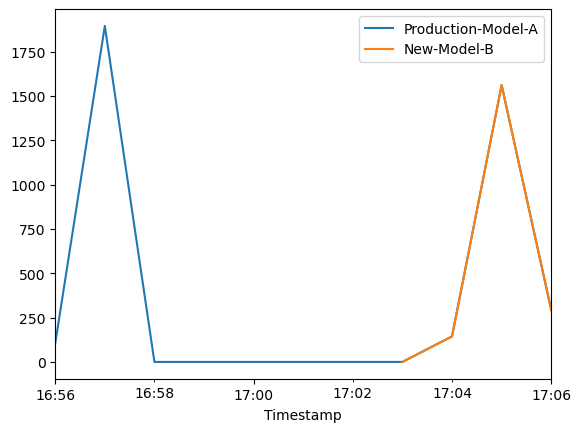

In [11]:
#get-cloudwatch-metrics
def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, 'Production-Model-A', start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, 'New-Model-B', start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

print("Waiting a minute for initial metric creation...")
time.sleep(120)  # The metrics and data capture need time to log and save all of the files
plot_endpoint_metrics()

In the table, you see the number of invocations for Model A, the production model. You also see the number of invocations for Model B, the new model. 

In the chart, you see the number of invocations per model variant over a period of time. 

You can see that the traffic starts out only on Model A. This behavior occurs because you sent traffic to the endpoint when the only model variant was the production model. Then, after the shadow model was added, you can see that the traffic is equivalent for both models. The lines overlap each other at every point. 

## Task 3.4: Evaluate the models with production data

All of the endpoint input and output data is captured with Data Capture. You can access the Data Capture logs and view each event by getting the log objects from the S3 bucket. When accessing the data, notice that the input is encoded as *CSV*. The data that is sent to the endpoint is included in *endpointInput*. The prediction is included in *endpointOutput*. Each inference event has a unique *eventId*, so you are able to match the production and shadow invocations based on their *eventId*. 

To evaluate the models, use the logs that are stored in the S3 bucket. With these logs, you can see the predictions that the production and shadow models generated from the single production endpoint.

First, view a log file from the data that was captured from the production variant.

In [12]:
#view-production-variant-data
current_endpoint_capture_prefix = "{}/{}/{}".format(data_capture_prefix, endpoint_name, 'Production-Model-A')
result = s3.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
prod_var_capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]

def get_obj_body(obj_key):
    return s3.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

prod_var_capture_file = get_obj_body(prod_var_capture_files[-1])
print(json.dumps(json.loads(prod_var_capture_file.split('\n')[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "0.353,0.262,0.086,0.402,0.149,0.083,0.158,0,1,0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "11.349684715270996\n",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "79ddad32-5aab-41fd-977f-c81cd5d39361",
    "inferenceTime": "2025-06-18T17:05:52Z"
  },
  "eventVersion": "0"
}


Then, convert the production variant captured data into a pandas dataframe.

In [13]:
#convert-production-data-to-pandas-dataframe
prod_input_list = []
for i in range(len(prod_var_capture_files)):
    prod_var_capture_file = get_obj_body(prod_var_capture_files[i])
    for i in range(len(prod_var_capture_file.split('\n'))):
        if not len(prod_var_capture_file.split('\n')[i]) == 0:
            prod_input = {}
            prod_input["input"] = json.loads(prod_var_capture_file.split('\n')[i])["captureData"]["endpointInput"]["data"]
            data = json.loads(json.loads(prod_var_capture_file.split('\n')[i])["captureData"]["endpointOutput"]["data"])
            prod_input["prod_output"] = data
            prod_input["eventId"] = json.loads(prod_var_capture_file.split('\n')[i])["eventMetadata"]["eventId"]
            prod_input_list.append(prod_input)

from pandas import json_normalize
prod_var_df = json_normalize(prod_input_list)
prod_var_df

,input,prod_output,eventId
0,"0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0",11.588634,5f3449f1-e5c0-453f-9637-89d1de1e0a47
1,"0.585,0.438,0.16,1.17,0.447,0.278,0.319,0,0,1",12.925363,dec551c8-3b57-42d6-bc60-dc6f5dc1c4c7
2,"0.581,0.481,0.179,1.058,0.465,0.242,0.267,0,1,0",12.444579,50e7846d-da4a-4919-8314-541db35de26b
3,"0.497,0.378,0.13,0.755,0.322,0.178,0.219,0,1,0",12.091702,2f8ae31f-c088-47c9-be12-805c0dece7a1
4,"0.654,0.526,0.213,1.323,0.632,0.327,0.368,0,0,1",12.858625,9e59bf48-aea0-47ef-a2f4-111f96a84d7c
...,...,...,...
1995,"0.555,0.446,0.129,1.123,0.473,0.257,0.29,0,1,0",12.770275,ef968f75-efc2-4801-9eaf-5a59d6f8cb31
1996,"0.624,0.514,0.144,1.027,0.377,0.262,0.245,0,0,1",11.904971,f5ed47a3-7166-4c45-b83a-d1bf5d818f0b
1997,"0.634,0.475,0.181,1.12,0.441,0.204,0.289,1,0,0",13.713738,7c33e403-4986-4424-90db-70f5dcc9351f
1998,"0.39,0.272,0.084,0.322,0.173,0.066,0.087,0,0,1",10.823192,e854fb58-67ac-4cdb-aa7c-65c8b45bbb3a


Next, view a log file from the data that was captured from the shadow variant.

In [14]:
#view-shadow-variant-data
current_endpoint_capture_prefix = "{}/{}/{}".format(data_capture_prefix, endpoint_name, 'New-Model-B')
result = s3.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
shadow_var_capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]

def get_obj_body(obj_key):
    return s3.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

shadow_var_capture_file = get_obj_body(shadow_var_capture_files[-1])
print(json.dumps(json.loads(shadow_var_capture_file.split('\n')[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "0.688,0.539,0.192,1.539,0.718,0.353,0.386,0,0,1",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "13.618392944335938\n",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "91a04e3c-50c9-4d35-967a-90c07e5bf05f",
    "invocationSource": "ShadowExperiment",
    "inferenceTime": "2025-06-18T17:05:53Z"
  },
  "eventVersion": "0"
}


Then, convert the shadow variant captured data into a pandas dataframe.

In [15]:
#convert-shadow-data-to-pandas-dataframe
shadow_input_list = []
for i in range(len(shadow_var_capture_files)):
    shadow_var_capture_file = get_obj_body(shadow_var_capture_files[i])
    for i in range(len(shadow_var_capture_file.split('\n'))):
        if not len(shadow_var_capture_file.split('\n')[i]) == 0:
            shadow_input = {}
            shadow_input["input"] = json.loads(shadow_var_capture_file.split('\n')[i])["captureData"]["endpointInput"]["data"]
            data = json.loads(json.loads(shadow_var_capture_file.split('\n')[i])["captureData"]["endpointOutput"]["data"])
            shadow_input["shadow_output"] = data
            shadow_input["eventId"] = json.loads(shadow_var_capture_file.split('\n')[i])["eventMetadata"]["eventId"]
            shadow_input_list.append(shadow_input)

shadow_var_df = json_normalize(shadow_input_list)
shadow_var_df

,input,shadow_output,eventId
0,"0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0",13.717491,5f3449f1-e5c0-453f-9637-89d1de1e0a47
1,"0.585,0.438,0.16,1.17,0.447,0.278,0.319,0,0,1",11.940685,dec551c8-3b57-42d6-bc60-dc6f5dc1c4c7
2,"0.679,0.564,0.167,1.395,0.609,0.275,0.407,0,0,1",13.647138,30a06a1a-808e-4af0-befb-8f93bfeed7b4
3,"0.289,0.235,0.072,0.002,0.001,0.001,0.03,1,0,0",10.327427,4657c674-72df-4222-b87f-b8efc00f4b04
4,"0.654,0.526,0.213,1.323,0.632,0.327,0.368,0,0,1",13.275390,9e59bf48-aea0-47ef-a2f4-111f96a84d7c
...,...,...,...
1995,"0.644,0.486,0.162,1.402,0.65,0.29,0.389,1,0,0",13.111516,adcd134e-517f-4c18-9011-d86b1b52340d
1996,"0.646,0.538,0.161,1.307,0.487,0.251,0.48,0,0,1",13.643486,c32ebf8c-0ff8-45d6-8eb5-88b0743c42ca
1997,"0.624,0.514,0.144,1.027,0.377,0.262,0.245,0,0,1",11.274489,f5ed47a3-7166-4c45-b83a-d1bf5d818f0b
1998,"0.607,0.438,0.151,1.194,0.51,0.281,0.372,0,1,0",13.148396,35e198ad-6ce1-45f3-acc0-eab317fd338d


Data Capture helps keep track of many model variants and their inference results during deployment. You can use the data that you just collected to see how the models compare.

Compare the predicted abalone ring values from the production and shadow variants. Append the ring labels from the original dataset to see the difference between the actual number of rings and the production output, and the actual number of rings and the shadow output.

When you are finished, the table includes:
- Headings for *eventId*
- The original *input*
- The production model output as *prod_output*
- The shadow model output as *shadow_output*
- The original *labels* that tell the actual age of the abalone
- The difference between the prod_output and the label as *prod_diff*
- The difference between the shadow_output and the label as *shadow_diff*.

In [16]:
#compile-data-capture-with-labels
df_with_labels = pd.read_csv("data/abalone_data_new.csv", header=None)
test_labels = df_with_labels.iloc[:, 0]

final_df = pd.merge(prod_var_df, shadow_var_df, on='eventId', how='right')
final_df['labels'] =  test_labels
final_df = final_df.drop('input_y', axis=1)
final_df = final_df.assign(prod_diff=final_df['prod_output'] - final_df['labels'])
final_df = final_df.assign(shadow_diff=final_df['shadow_output'] - final_df['labels'])
final_df = final_df[['eventId','input_x','prod_output','shadow_output','labels','prod_diff','shadow_diff']]
final_df

,eventId,input_x,prod_output,shadow_output,labels,prod_diff,shadow_diff
0,5f3449f1-e5c0-453f-9637-89d1de1e0a47,"0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0",11.588634,13.717491,13,-1.411366,0.717491
1,dec551c8-3b57-42d6-bc60-dc6f5dc1c4c7,"0.585,0.438,0.16,1.17,0.447,0.278,0.319,0,0,1",12.925363,11.940685,11,1.925363,0.940685
2,30a06a1a-808e-4af0-befb-8f93bfeed7b4,"0.679,0.564,0.167,1.395,0.609,0.275,0.407,0,0,1",13.367835,13.647138,10,3.367835,3.647138
3,4657c674-72df-4222-b87f-b8efc00f4b04,"0.289,0.235,0.072,0.002,0.001,0.001,0.03,1,0,0",10.631181,10.327427,11,-0.368819,-0.672573
4,9e59bf48-aea0-47ef-a2f4-111f96a84d7c,"0.654,0.526,0.213,1.323,0.632,0.327,0.368,0,0,1",12.858625,13.275390,13,-0.141375,0.275390
...,...,...,...,...,...,...,...
1995,adcd134e-517f-4c18-9011-d86b1b52340d,"0.644,0.486,0.162,1.402,0.65,0.29,0.389,1,0,0",12.305834,13.111516,12,0.305834,1.111516
1996,c32ebf8c-0ff8-45d6-8eb5-88b0743c42ca,"0.646,0.538,0.161,1.307,0.487,0.251,0.48,0,0,1",13.562231,13.643486,13,0.562231,0.643486
1997,f5ed47a3-7166-4c45-b83a-d1bf5d818f0b,"0.624,0.514,0.144,1.027,0.377,0.262,0.245,0,0,1",11.904971,11.274489,10,1.904971,1.274489
1998,35e198ad-6ce1-45f3-acc0-eab317fd338d,"0.607,0.438,0.151,1.194,0.51,0.281,0.372,0,1,0",12.725035,13.148396,13,-0.274965,0.148396


Review each prediction's variance and see how far each prediction is from the actual values. During the shadow deployment, each inference request was sent to both models. Thus, the results include 2000 predictions from the production model and 2000 predictions from the shadow model. The most straightforward way to evaluate the predictions is as follows: Find the absolute value of the difference between the prediction and the actual value, and then average these differences.

For instance, if the abalone has 11 rings, but the production prediction is 9.3, the difference between these values is -1.7. The absolute value of -1.7 is 1.7. Find the absolute value for every difference, add them up, and divide the total by the number of inferences. In this way, you can find the average difference of the absolute values. A lower average difference means that the model predictions are generally more accurate.

In [17]:
#calculate-average-absolute-difference
prod_diff_average = final_df.loc[:, 'prod_diff'].abs().mean()
shadow_diff_average = final_df.loc[:, 'shadow_diff'].abs().mean()

print("These are the averages of the absolute value of the difference between each model's inference results and the actual values (lower scores are more accurate):")
print("Production model variant: {}".format(prod_diff_average))
print("Shadow model variant: {}".format(shadow_diff_average))

These are the averages of the absolute value of the difference between each model's inference results and the actual values (lower scores are more accurate):
Production model variant: 1.2885243582725525
Shadow model variant: 1.5040638756752014


In this case, the shadow model has a higher average difference than the production model variant. This result indicates that the shadow model is likely not as good at predicting the actual number of rings as the current production model.

You can see the results in more detail by creating charts of the data you collected from the Data Capture logs. Graph the average difference of the number of rings for the production and shadow models. This graph shows you, for each number of rings, how close each model is to predicting the correct value.

[Text(0.5, 1.0, 'Difference in Prediction Scores by Number of Rings'),
 Text(0.5, 0, 'Number of Rings'),
 Text(0, 0.5, 'Absolute Difference in Predicted to Actual Rings')]

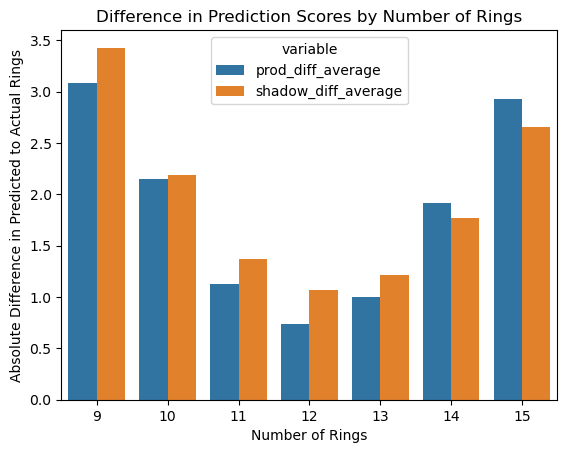

In [18]:
#graph-model-differences-from-labels
final_df['prod_diff'] = final_df['prod_diff'].abs()
final_df['shadow_diff'] = final_df['shadow_diff'].abs()
grouped_df = final_df.groupby(['labels']).agg(prod_diff_average=('prod_diff', 'mean'), shadow_diff_average=('shadow_diff' , 'mean'))
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.melt(id_vars=['labels'], value_vars=['prod_diff_average', 'shadow_diff_average'])

sb.barplot(x=grouped_df.labels,
           y=grouped_df.value,
           hue=grouped_df.variable,
           data=grouped_df).set(title='Difference in Prediction Scores by Number of Rings', xlabel='Number of Rings', ylabel='Absolute Difference in Predicted to Actual Rings')

This chart shows that the production and shadow models have similar variances for each ring value. The production model has lower variance for some of the ring values, and the shadow model has lower variance for other ring values.

You have collected a list of predicted values. Now, you can evaluate the R-squared score (R2 score), mean absolute error (MAE), and root mean squared error (RMSE) metrics for each variant. These metrics help determine whether the new model is an improvement over the one currently in production.

In [21]:
#evaluate-model-metrics
labels = final_df['labels']
prod_preds = final_df['prod_output']
shadow_preds = final_df['shadow_output']

# Calculate R2
prod_score = r2_score(labels, prod_preds)
shadow_score = r2_score(labels, shadow_preds)
print("The R2 score of the production model is {}".format(round(prod_score, 2)))
print("The R2 score of the shadow model is {}\n".format(round(shadow_score, 2)))

# Calculate MAE
prod_score = mean_absolute_error(labels, prod_preds)
shadow_score = mean_absolute_error(labels, shadow_preds)
print("The Mean Absolute Error of the production model is {}".format(round(prod_score, 2)))
print("The Mean Absolute Error of the shadow model is {}\n".format(round(shadow_score, 2)))

# Calculate RMSE
prod_score = root_mean_squared_error(labels, prod_preds)
shadow_score = root_mean_squared_error(labels, shadow_preds)
print("The Root Mean Squared Error of the production model is {}".format(round(prod_score, 2)))
print("The Root Mean Squared Error of the shadow model is {}\n".format(round(shadow_score, 2)))

The R2 score of the production model is -0.52
The R2 score of the shadow model is -1.07

The Mean Absolute Error of the production model is 1.29
The Mean Absolute Error of the shadow model is 1.5

The Root Mean Squared Error of the production model is 1.61
The Root Mean Squared Error of the shadow model is 1.88



The shadow model is not performing as well as the current production model. The R2 score is lower, the MAE is higher, and the RMSE is higher. With a lower R2 score, you are confident that the shadow model is not improvement over the current production model. The team is going back to testing and tuning the model so they can try to improve on these results.

You have successfully implemented a shadow testing strategy by configuring and testing production and shadow model variants. You reviewed results from the production and shadow model variants, and identified the model with the best performance.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with the **Conclusion**.